# enrichment function

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Compute the p-values

In [3]:
test = "../data/tests/test_data/input/03_srf_hg19.bed"
regdom = "../data/human/hg19/regulatory_domain.bed"
great_out = "../data/tests/test_data/output/03_srf_hg19_output_great_webserver.tsv"
size = "../data/human/hg19/chr_size.bed"

In [4]:
enrichment = great.tl.Great.enrichment(
    test_file = test,
    regdom_file = regdom,
    chr_size_file = size,
    annotation_file = "../data/human/ontologies.csv",
    binom = True,
    hypergeom = True,
    )
great.tl.Great.set_fdr(enrichment)
great.tl.Great.set_bonferroni(enrichment)
enrichment

,go_term,binom_p_value,binom_fold_enrichment,hypergeom_p_value,hypergeometric_fold_enrichment,intersection_size,recall,binom_fdr,hypergeom_fdr,binom_bonferroni,hypergeom_bonferroni
GO:0072749,cellular response to cytochalasin B,2.21968e-12,2.27251e+05,4.28032e-02,2.33627e+01,5,5.00000e+00,4.61693e-09,4.65089e-01,9.23386e-09,1.00000e+00
GO:0051623,positive regulation of norepinephrine uptake,2.21968e-12,2.27251e+05,4.28032e-02,2.33627e+01,5,5.00000e+00,4.61693e-09,4.65089e-01,9.23386e-09,1.00000e+00
GO:0098973,structural constituent of postsynaptic actin c...,2.11740e-10,9.10526e+04,1.60543e-01,5.84068e+00,5,1.25000e+00,2.93613e-07,5.43858e-01,8.80839e-07,1.00000e+00
GO:0097433,dense body,6.40085e-10,1.60618e+04,1.41783e-03,1.16814e+01,8,1.33333e+00,6.65688e-07,3.65408e-01,2.66275e-06,1.00000e+00
GO:0032796,uropod organization,2.69880e-09,5.45449e+04,1.82991e-03,2.33627e+01,5,2.50000e+00,1.93909e-06,3.65408e-01,1.12270e-05,1.00000e+00
...,...,...,...,...,...,...,...,...,...,...,...
GO:0007156,homophilic cell adhesion via plasma membrane a...,9.99960e-01,1.12747e+02,9.84651e-01,3.89379e-01,3,1.66667e-02,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0007186,G protein-coupled receptor signaling pathway,9.99992e-01,2.46644e+02,1.00000e+00,3.07404e-01,19,1.47059e-02,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0016021,integral component of membrane,9.99997e-01,3.94493e+02,9.99998e-01,7.05221e-01,112,2.88958e-02,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00
GO:0005887,integral component of plasma membrane,1.00000e+00,2.81852e+02,9.99970e-01,5.84068e-01,40,2.50000e-02,1.00000e+00,1.00000e+00,1.00000e+00,1.00000e+00


## Compare p values between binomial and hypergeometric tests 

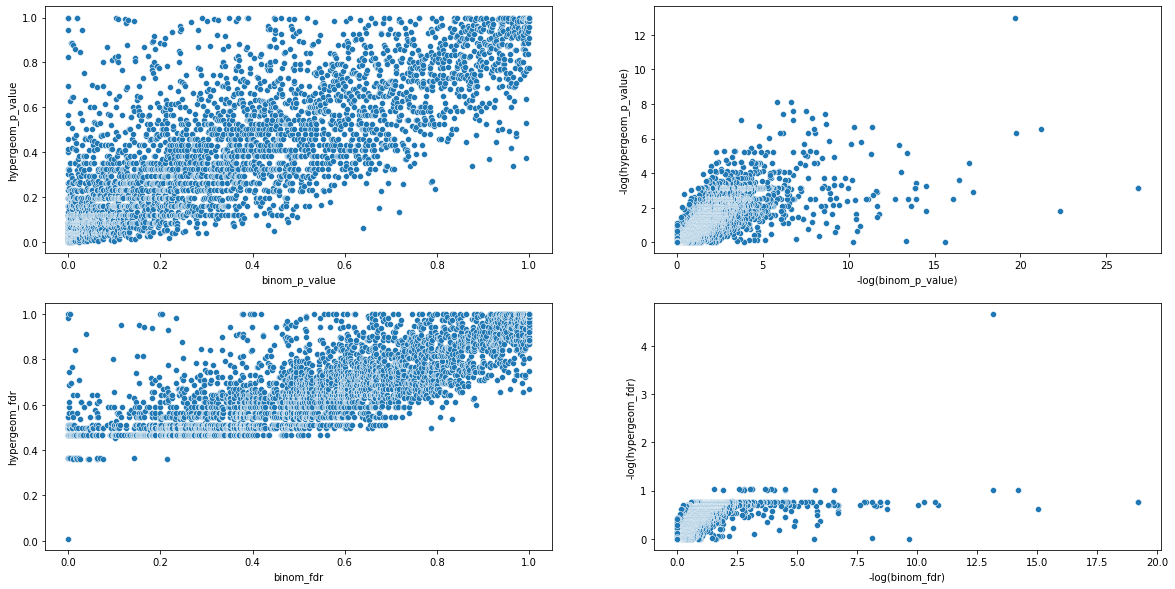

In [5]:
fig,ax = plt.subplots(2,2,figsize = (20,10))
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10 = False,ax = ax[0,0])
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10 = True,ax = ax[0,1])
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10 = False,ax = ax[1,0])
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10 = True,ax = ax[1,1])
plt.show()

In [7]:
pd.options.display.float_format = "{:.3f}".format
pd.DataFrame({
        "binom_vs_hyper": [cov(m = list(enrichment["binom_p_value"]), y = list(enrichment["hypergeom_p_value"]))[0][1],pearsonr(list(enrichment["binom_p_value"]), list(enrichment["hypergeom_p_value"]))[0]],
        "binom_fdr_vs_hyper_fdr":[cov(m = list(enrichment["binom_fdr"]), y = list(enrichment["hypergeom_fdr"]))[0][1],pearsonr(list(enrichment["binom_fdr"]), list(enrichment["hypergeom_fdr"]))[0]]},
        index = ["cov","pearson"])

,binom_vs_hyper,binom_fdr_vs_hyper_fdr
cov,0.062,0.030
pearson,0.773,0.758


The covariance between the binomial and hypergeometric values is very close to 0 (`e-2`). There is therefore no or little correlation between the variance of these two data 

As we can see here, the correlation is quite good (~`0.75`) between the binomial and hypergeometric values returned by great. 

We can explain this difference by the fact that the two statistical tests are not susceptible to the same biases and are therefore complementary. 

The biases for the two tests are : 

* The hypergeometric test may be biased by the size of the regulatory domains of the genes since isolated genes have very large regulatory domains and are therefore more likely to generate false positives

* The binomial test can also be biased if a large number of genomic regions to be tested are associated with a small set of genes that can also generate false positives